In [19]:
%run 'init.ipynb'
save = get_figsave('1_2_');

In [2]:
a_1, a_2, r, x, y = sp.symbols('a_1, a_2, r, x, y')

xdot = a_1 / (1 + y**r) - x
ydot = a_2 / (1 + x**r) - y

eq_x = sp.solve(xdot.subs(r, 0), x)[0]
eq_y = sp.solve(ydot.subs(r, 0), y)[0]

eq_x, eq_y

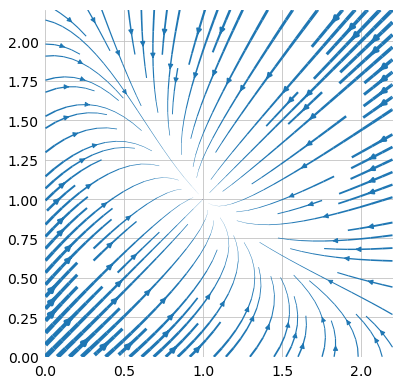

In [7]:
xdot_np = sp.lambdify((x, y, r), xdot.subs(a_1, 2))
ydot_np = sp.lambdify((x, y, r), ydot.subs(a_2, 2))

def get_field(xmax, r=1):
    xgrid, ygrid = np.meshgrid(np.linspace(0, xmax, 200),
                               np.linspace(0, xmax, 200))
    with ignore(RuntimeWarning):
        xdot_grid = xdot_np(xgrid, ygrid, r)
        ydot_grid = ydot_np(xgrid, ygrid, r)
    return xgrid, ygrid, xdot_grid, ydot_grid

field = get_field(2.2, r=1)
fig, ax = streamplot(*field, speed=True)
save(fig, 'streamline_close');

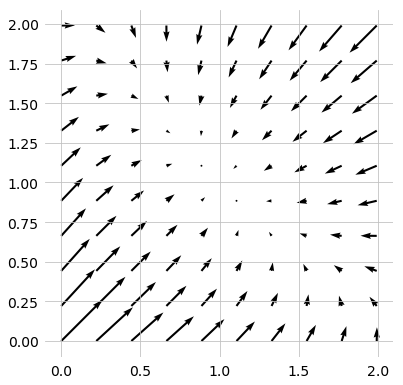

In [4]:
fig, ax = quiver(*field, subsample=20)
save(fig, 'quiver_close');

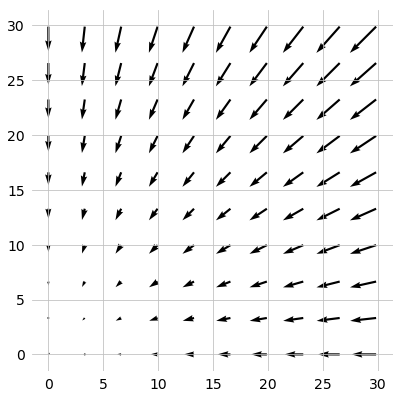

In [5]:
field_large = get_field(33, r=1)
fig, ax = quiver(*field_large, subsample=20)
save(fig, 'quiver_far');

In [33]:
from scipy.integrate import solve_ivp

rr = 1

def f(t, y):
    return (
        xdot_np(y[0], y[1], rr),
        ydot_np(y[0], y[1], rr),
    )

y_0 = (1.2, 1)
t_span = (0, -10)

sol = solve_ivp(f, t_span, y_0)
sol.y

array([[1.20000000e+00, 1.23044738e+00, 1.76651099e+00, 4.51968492e+00,
        1.58019272e+01, 6.05648771e+01, 2.41370047e+02, 9.77997670e+02,
        3.99016629e+03, 7.80910717e+03],
       [1.00000000e+00, 1.01449549e+00, 1.35114210e+00, 3.34422957e+00,
        1.16627081e+01, 4.46970348e+01, 1.78131466e+02, 7.21763770e+02,
        2.94474880e+03, 5.76313298e+03]])

## r > 2

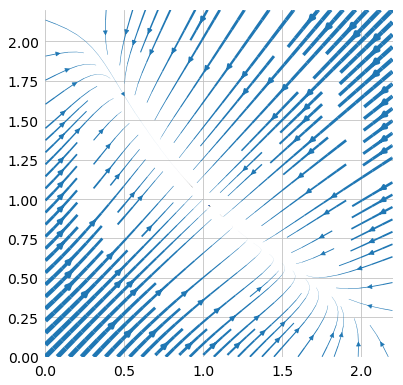

In [10]:
field = get_field(2.2, r=2)
streamplot(*field, speed=True);

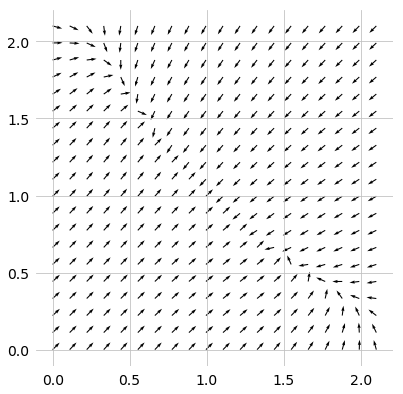

In [16]:
quiver(*field, subsample=10, dir_only=True);